In [1]:
import os
import glob
import anndata
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from scipy.stats import linregress, spearmanr, pearsonr
import math
import seaborn as sns
from sklearn import preprocessing

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
def rename_lambdas_index_genes(lambdas_file): 
    nwe=[]
    nm=lambdas_file.index
    for item in nm:
        nwe.append(str(item).split("_")[0])
    return nwe

In [4]:
# Load Lambda pmean df
path = '../../smomics_data'

# Read mRNA
filename = os.path.join("/Users/svickovi/Desktop/tags/introns/STB58", 'lambdas_pmeans.tsv')
lambda_posterior_means = pd.read_csv(filename, index_col=0, sep='\t', header=[0,1],low_memory=False)
lambda_posterior_means.index = rename_lambdas_index_genes(lambda_posterior_means)
lambda_posterior_means = lambda_posterior_means.astype(float)
lambda_posterior_means = np.exp(lambda_posterior_means-1)

filename = os.path.join(path, 'lambdas_pmeans_spleen_exons_mRNA_ifs.tsv')
lambda_posterior_means2 = pd.read_csv(filename, index_col=0, sep='\t', header=[0,1],low_memory=False)
lambda_posterior_means2.index = rename_lambdas_index_genes(lambda_posterior_means2)
lambda_posterior_means2 = lambda_posterior_means2.astype(float)
lambda_posterior_means2 = np.exp(lambda_posterior_means2-1)


In [5]:
#Read tags
filename = os.path.join(path, 'lambdas_pmeans_spleen_exons_tags_ifs.tsv')
lambda_posterior_means_tags = pd.read_csv(filename, index_col=0, sep='\t', header=[0,1],low_memory=False)
lambda_posterior_means_tags = lambda_posterior_means_tags.astype(float)
lambda_posterior_means_tags = np.exp(lambda_posterior_means_tags-1)
lambda_posterior_means_tags.index = [i.split("-")[0]+"_Totalseq" for i in lambda_posterior_means_tags.index]

In [60]:
#Read ifs
filename = os.path.join(path, 'lambdas_pmeans_spleen_exons_ifs_ifs.tsv')
lambda_posterior_means_ifs = pd.read_csv(filename, index_col=0, sep='\t', header=[0,1],low_memory=False)
lambda_posterior_means_ifs = lambda_posterior_means_ifs.astype(float)
lambda_posterior_means_ifs = np.exp(lambda_posterior_means_ifs-1)
lambda_posterior_means_ifs.index = ['F480_IF', 'IgD_IF']

In [61]:
genes = ['Adgre1', 'Ighd', 'Cd8a', 'Cd4', 'Cd38', 'Cd163']
collect_df = []
tmp_lambda_output_all = []
for count, file in enumerate(np.unique([i.split("/")[-1] for i in lambda_posterior_means.columns.get_level_values(0)])):
    
    # reads in mRNA counts files
    name = file.split("_stdata_adjusted.tsv")[0]
    print(name)
        
    if name == '10015CN88_D2':
        continue
        
    counts = pd.read_csv(os.path.join("/Users/svickovi/Desktop/tags/introns/STB58/counts_tabls",file), sep = "\t", header = [0], index_col = [0]).T
    counts = counts.drop(genes, axis = 1)
    print(counts.sum(axis = 1))
    
    counts2 = pd.read_csv(os.path.join("/Users/svickovi/Desktop/tags/exons/STB58/counts_tables",file), sep = "\t", header = [0], index_col = [0]).T
    counts2 = counts2[genes]
    counts = pd.merge(counts, counts2, left_index = True, right_index = True)
    
    print(name)
    counts.to_csv(os.path.join(path,name+'_stdata_adjusted_new.tsv'), sep = "\t", index = True)
    print(round(np.mean(counts.sum(axis = 1))))
    print(round(np.std(counts.sum(axis = 1))))
    
    anns = pd.read_csv(os.path.join(path,name+"_stdata_adjusted.tsv.annotations.tsv"), sep = "\t", header = [0], index_col = [0]).T
    ann_list = []
    coor_list = []
    
    # gets annotations
    for ind, coor in enumerate(anns.index):
        ann_list.append(anns.iloc[ind][anns.iloc[ind] == 1].index)
        coor_list.append(coor)
    anndf = pd.DataFrame(ann_list, index = coor_list, columns = ['region'])
    anndf = anndf[~anndf.region.isin(['White pulp'])]
    dfmerge = pd.merge(counts, anndf, left_index = True, right_index = True)
    features_genes = ['Gene expression']*(len(dfmerge.columns)-1)
         
    # gets tags or ifs data 
    tags = pd.read_csv(os.path.join(path,name+"_stdata_adjusted_tags.tsv"), sep = "\t", header = [0], index_col = [0]).T
    tags.columns = [i.split("-")[0]+"_Totalseq" for i in tags.columns]
    features_tags = ['Antibody Capture']*len(tags.columns)
    dfmerge_tags =  pd.merge(dfmerge, tags, left_index = True, right_index = True) 
    
    # gets IF files 
    ifs = pd.DataFrame([], index = dfmerge_tags.index)
    for ab in [i.split("_")[0] for i in tags.columns]:
        if ab in ['F480', 'IgD']:
            ifs = pd.merge(ifs, pd.read_csv(os.path.join(path, name+"_"+ab+"_intensitites.tsv"), sep = "\t", header = [0], index_col = [0]).T, left_index = True, right_index = True)
    ifspd = ifs
    ifspd = ifspd.replace(np.nan, 0)
    ifspd.columns = [i+"_IF" for i in ifspd.columns]
    ifspd.T.to_csv(os.path.join(path, name+"_intensitites.tsv"), sep = "\t", index = True)
    features_ifspd = ['IF Capture']*len(ifspd.columns)
 
    # merge ifs with rest 
    dfmerge_all =  pd.merge(dfmerge_tags, ifspd, left_index = True, right_index = True)   
    
    # merge with normalized mRNA counts 
    tmp_lambda = lambda_posterior_means[os.path.dirname(lambda_posterior_means.columns.get_level_values(0)[0])+"/"+file].T
    tmp_lambda = tmp_lambda[tmp_lambda.index.isin(dfmerge_all.index)].reindex(dfmerge_all.index)
    tmp_lambda = tmp_lambda.reindex(dfmerge.index, axis=0)
    #print(tmp_lambda[genes])
    
    # merge with normalized mRNA counts 
    tmp_lambda2 = lambda_posterior_means2[os.path.dirname(lambda_posterior_means2.columns.get_level_values(0)[0])+"/"+file].T
    tmp_lambda2 = tmp_lambda2[tmp_lambda2.index.isin(tmp_lambda.index)].reindex(tmp_lambda.index)
    tmp_lambda2 = tmp_lambda2.reindex(tmp_lambda.index, axis=0)
    tmp_lambda2 = tmp_lambda2[genes]
    #print(tmp_lambda2)
    tmp_lambda = tmp_lambda.drop(genes, axis = 1)
    tmp_lambda = pd.merge(tmp_lambda, tmp_lambda2, left_index = True, right_index = True) 
    
    # merge with normalized tag counts
    tag_lambda = lambda_posterior_means_tags[os.path.dirname(lambda_posterior_means_tags.columns.get_level_values(0)[0])+"/"+file].T
    tag_lambda = tag_lambda[tag_lambda.index.isin(dfmerge_all.index)].reindex(dfmerge_all.index)
    tag_lambda = tag_lambda.reindex(dfmerge_tags.index, axis=0)
    
    # merge with normalized intensities
    ifs_lambda = lambda_posterior_means_ifs[os.path.dirname(lambda_posterior_means_ifs.columns.get_level_values(0)[0])+"/"+file].T
    ifs_lambda = ifs_lambda[ifs_lambda.index.isin(dfmerge_all.index)].reindex(dfmerge_all.index)
    ifs_lambda = ifs_lambda.reindex(dfmerge_tags.index, axis=0)  
    print(len(ifs_lambda.index))
    
    # merge counts and annotations and make anndata objects
    obs = dfmerge_all['region']
    obs.index = [name+"_"+i for i in obs.index]
    dfmerge_all.drop(['region'], axis = 1, inplace = True)
    
    # subset to relevant genes/abs
#     dfmerge_all = dfmerge_all[['Cd8a', 'Cd4', 'Ighd', 'Adgre1', 'Cd38', 'Cd163']+
#                 dfmerge_all.columns[dfmerge_all.columns.str.contains('Totalseq')].to_list()+
#                 dfmerge_all.columns[dfmerge_all.columns.str.contains('_IF')].to_list()]
#     dfmerge_all.index = [name+"_"+i for i in dfmerge_all.index] 
    
    a = anndata.AnnData(X=dfmerge_all.values, obs=pd.DataFrame(obs),)
    a.var_names = dfmerge_all.columns
    #a.var["feature_types"] = features_genes[0:6]+features_tags+features_ifspd
    a.var["feature_types"] = features_genes+features_tags+features_ifspd
    a.var_names_make_unique()
    a.layers["counts"] = a.X.copy()
    a.raw = a.copy()
    
    # add normalized data
    dfmerge_norm =  pd.merge(tmp_lambda, tag_lambda, left_index = True, right_index = True)
    dfmerge_norm_ifs = pd.merge(dfmerge_norm, ifs_lambda, left_index = True, right_index = True)
    dfmerge_norm_ifs.drop(['coordinate'], axis = 1, inplace = True)
    dfmerge_norm_ifs = dfmerge_norm_ifs.dropna(axis = 0)
    
    # subset to relevant genes/abs
#     dfmerge_norm_ifs = dfmerge_norm_ifs[['Cd8a', 'Cd4', 'Ighd', 'Adgre1', 'Cd38', 'Cd163']+
#                 dfmerge_norm_ifs.columns[dfmerge_norm_ifs.columns.str.contains('Totalseq')].to_list()+
#                 dfmerge_norm_ifs.columns[dfmerge_norm_ifs.columns.str.contains('_IF')].to_list()]
    dfmerge_norm_ifs.index = [name+"_"+i for i in dfmerge_norm_ifs.index] 
    
    collect_df.append(pd.merge(dfmerge_norm_ifs, a.obs, left_index = True, right_index = True))
    
    # add norm data to anndatas
    a = a[:,dfmerge_norm_ifs.columns]
    a = a[dfmerge_norm_ifs.index,:]
    a.X = dfmerge_norm_ifs.values
    a.var_names_make_unique()
    a = a[:,np.sort(a.var_names)]
         
    # writes out anndatas
    if count == 0:
        anndatas_all = a
    else: 
        anndatas_all = anndata.AnnData.concatenate(anndatas_all,a,)
anndatas_all.obs.index = [i.split("-")[0] for i in anndatas_all.obs.index]
anndatas_all.obs.drop('batch', axis = 1, inplace = True)
#anndatas_all.write_h5ad(filename=os.path.join(path, "smomics_anndata_ifs.h5ad"))

10015CN88_D1
5_15     1745
23_15    2442
25_20    3092
8_6      1613
24_25    2793
         ... 
2_7       678
20_26    2253
26_18    2934
20_19    1713
10_15    1591
Length: 570, dtype: int64
10015CN88_D1
2180
639
570


Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


10015CN88_D2
10015CN88_E1
12_26    1831
7_25     1436
23_14    1557
18_7     2237
26_9     3010
         ... 
13_8     1650
17_25    1572
11_19    2060
2_33     2753
15_22    1696
Length: 521, dtype: int64
10015CN88_E1
1901
510
521


Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


10015CN88_E2
9_27     1603
11_22    1919
12_23    2050
11_32    1750
7_17     1159
         ... 
8_17     1810
15_12    2117
21_11    1901
11_11    1931
12_21    2074
Length: 526, dtype: int64
10015CN88_E2
1768
524
526


Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [62]:
#write out lambdas
mlt = pd.DataFrame([i.split('_')[2]+'_'+i.split('_')[3] for i in anndatas_all.obs.index])
mlt['file'] = [lambda_posterior_means2.columns.get_level_values(0)[0]+"/"+i.split('_')[0]+'_'+i.split('_')[1]+"_stdata_adjusted.tsv" for i in anndatas_all.obs.index]
mlt.columns = ['coordinate','file']
mlt = mlt[['file', 'coordinate']]
df = pd.DataFrame(anndatas_all.X, columns = anndatas_all.var_names, index = anndatas_all.obs.index).T
df.columns = mlt.set_index(['file', 'coordinate'], inplace=False).index
#df.to_csv(os.path.join(path,'lambdas_pmeans_spleen_exons_mRNA_ifs_new.tsv'), sep = "\t", index = True)

In [63]:
df = pd.concat(collect_df).dropna(axis=0)
region = pd.concat(collect_df).dropna(axis=0)['region']
df = pd.DataFrame(anndatas_all.X, columns = anndatas_all.var_names, index = anndatas_all.obs.index)
df = df[['Cd8a', 'Cd4', 'Ighd', 'Adgre1', 'Cd38', 'Cd163']+
                dfmerge_all.columns[dfmerge_all.columns.str.contains('Totalseq')].to_list()+
                 dfmerge_all.columns[dfmerge_all.columns.str.contains('_IF')].to_list()]
df['image'] = [i.split("_")[0]+"_"+i.split("_")[1] for i in df.index]
df['region'] = region.to_list()

In [64]:
df = df.groupby(['image','region']).mean()

In [65]:
df = df.groupby(['image']).transform(lambda x: preprocessing.minmax_scale(x))

In [66]:
df

Cd8a       Cd4      Ighd    Adgre1  \
image        region                                                      
10015CN88_D1 B follicle     9.999999e-01  1.000000  1.000000  0.685105   
             Marginal zone  2.465014e-14  0.000000  0.153479  0.000000   
             PALS           0.000000e+00  0.547536  0.653523  0.439191   
             Red pulp       8.028623e-01  0.433721  0.000000  1.000000   
10015CN88_E1 B follicle     1.000000e+00  1.000000  1.000000  0.681090   
             Marginal zone  2.605061e-14  0.000000  0.167161  0.000000   
             PALS           0.000000e+00  0.546005  0.625198  0.464684   
             Red pulp       7.817543e-01  0.432085  0.000000  1.000000   
10015CN88_E2 B follicle     1.000000e+00  1.000000  1.000000  0.666117   
             Marginal zone  2.687697e-14  0.000000  0.201024  0.000000   
             PALS           0.000000e+00  0.534521  0.607217  0.442100   
             Red pulp       7.921720e-01  0.448337  0.000000  1.000000   

                                Cd38     Cd163  F480_Totalseq  IgD_Totalseq  \
image        region                                                           
10015CN88_D1 B follicle     1.000000  0.427215       0.000000      1.000000   
             Marginal zone  0.029707  0.000000       0.854397      0.151350   
             PALS           0.558097  0.422787       0.319947      0.658546   
             Red pulp       0.000000  1.000000       1.000000      0.000000   
10015CN88_E1 B follicle     1.000000  0.425220       0.000000      1.000000   
             Marginal zone  0.000000  0.000000       0.179814      0.842890   
             PALS           0.724793  0.424869       0.069040      0.880197   
             Red pulp       0.292057  1.000000       1.000000      0.000000   
10015CN88_E2 B follicle     1.000000  0.415530       0.000000      1.000000   
             Marginal zone  0.000000  0.000000       0.128488      0.856538   
             PALS           0.708369  0.412217       0.408023      0.579854   
             Red pulp       0.352479  1.000000       1.000000      0.000000   

                             F480_IF    IgD_IF  
image        region                             
10015CN88_D1 B follicle     0.000000  1.000000  
             Marginal zone  0.644816  0.354611  
             PALS           0.943427  0.057413  
             Red pulp       1.000000  0.000000  
10015CN88_E1 B follicle     0.000000  1.000000  
             Marginal zone  0.495329  0.503332  
             PALS           0.733921  0.265992  
             Red pulp       1.000000  0.000000  
10015CN88_E2 B follicle     0.000000  1.000000  
             Marginal zone  0.220554  0.779004  
             PALS           0.853417  0.143798  
             Red pulp       1.000000  0.000000

Adgre1
std err:0.325
Spearman's rho: 0.26
p-value: 0.4163057139577694
Ighd
std err:0.194
Spearman's rho: 0.92
p-value: 2.8674693974755723e-05


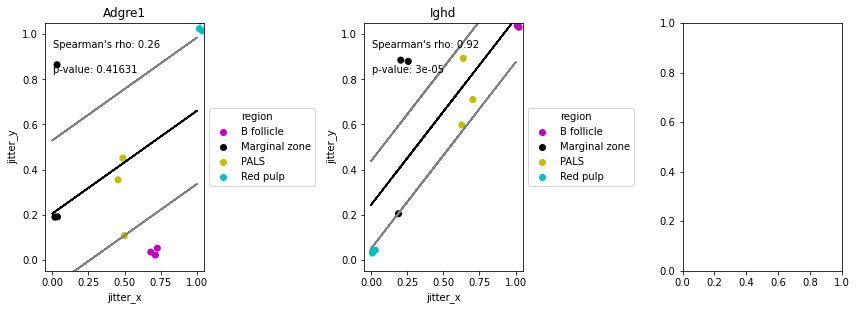

In [70]:
# initialize a figure
fig = matplotlib.pyplot.figure(figsize=(12, 8))
num_cols = 3
axes = []

for i in range(0,int((int(len(genes)+2)/num_cols))):
    for j in range(0, num_cols):
        ax = plt.subplot2grid((int((len(genes)+2)/num_cols+1), num_cols), (i, j))
        axes.append(ax) 

genes = ['Adgre1', 'Ighd', ]

for count, gene in enumerate(genes):
    ax = axes[count]
    
    if gene == "Adgre1":
        tag = "F480_Totalseq"
    if gene == "Ighd":
        tag = "IgD_Totalseq"
 

    plot_trans = df[[gene,tag, ]]
    plot_trans['region'] = plot_trans.index.get_level_values(1)
    plot_trans = plot_trans[~plot_trans.index.get_level_values(0).isin(['10015CN87D1',])]

    plot_trans['jitter_y'] = plot_trans[tag] + 0.05 * np.random.rand(len(plot_trans[tag].tolist())) +0.01
    plot_trans['jitter_x'] = plot_trans[gene] + 0.05 * np.random.rand(len(plot_trans[gene].tolist())) +0.01
    x = 'jitter_x'
    y = 'jitter_y'
    hue = 'region'
    palette = {'Red pulp':'c', 'B follicle':'m', 'PALS':'y', 'Marginal zone':'k', 'White pulp':'r', 'IGDpos':'b'}
    data = plot_trans

    sns.scatterplot(x=x, y=y, data=data, ax=ax, hue=hue, s=50, linewidth=0, palette=palette)

    # Calculate the linear regression
    X = gene
    Y = tag

    slope, intercept, r_value, p_value, std_err = linregress(data[X], data[Y])

    print(gene)
    print('std err:' + str(round(std_err, 3)))

    coef = np.polyfit(data[X],data[y],1)
    poly1d_fn = np.poly1d(coef)
    ax.plot(data[X], poly1d_fn(data[X]), c="k")
    ax.plot(data[X], poly1d_fn(data[X])+std_err, c="grey")
    ax.plot(data[X], poly1d_fn(data[X])-std_err, c="grey")
    #ax.errorbar(trans[x], poly1d_fn(trans[x]), yerr=poly1d_fn(trans[x]) - trans[y], fmt='.k')

    # Spearman's & Pearson's r
    spear, ps = spearmanr(data[X], data[Y])
    pear, pp = pearsonr(data[X], data[Y])
    print("Spearman's rho: " + str(round(spear, 2)))
    print("p-value: " + str(ps))

    ax.text(0.05, 0.9, "Spearman's rho: " + str(round(spear, 2)), transform=ax.transAxes, fontsize=10)
    ax.text(0.05, 0.8, "p-value: " + str(round(ps, 5)), transform=ax.transAxes, fontsize=10)
    #ax.get_legend().remove()

    # title
    ax.set_title(gene)

    ax.set_xlim([-0.05, 1.05])
    ax.set_ylim([-0.05, 1.05])
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.tight_layout()

